# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import json
import pandas as pd
import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal data .

In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-17 19:25 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-17 19:25 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-17 19:25 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-17 19:25 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-17 19:25 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-17 19:25 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-17 19:25 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-17 19:25 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-17 19:25 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 1.25 ms, sys: 6.86 ms, total: 8.11 ms
Wall time: 1.59 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 13.1 ms, sys: 8.49 ms, total: 21.6 ms
Wall time: 54.1 s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 19.4 ms, sys: 7.76 ms, total: 27.2 ms
Wall time: 1min 30s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 15.5 ms, sys: 988 µs, total: 16.5 ms
Wall time: 25.3 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (179621, (5.0, ['179621', 'Frau Holle (2008)'])),
 (207642, (5.0, ['207642', 'Kabir Singh (2019)'])),
 (164620, (5.0, ['164620', 'Zig Zag Story (1983)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (115795, (5.0, ['115795', 'Bronx Obama (2014)'])),
 (83161, (5.0, ['83161', 'Deadly Delicious (Shuang Shi Ji) (2008)'])),
 (165285, (5.0, ['165285', 'Homeless for the Holidays (2009)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-17 19:29 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58962 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112506 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131450 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114305 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133476 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117792 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143092 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132298 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167639 2021-02-17 19:29 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

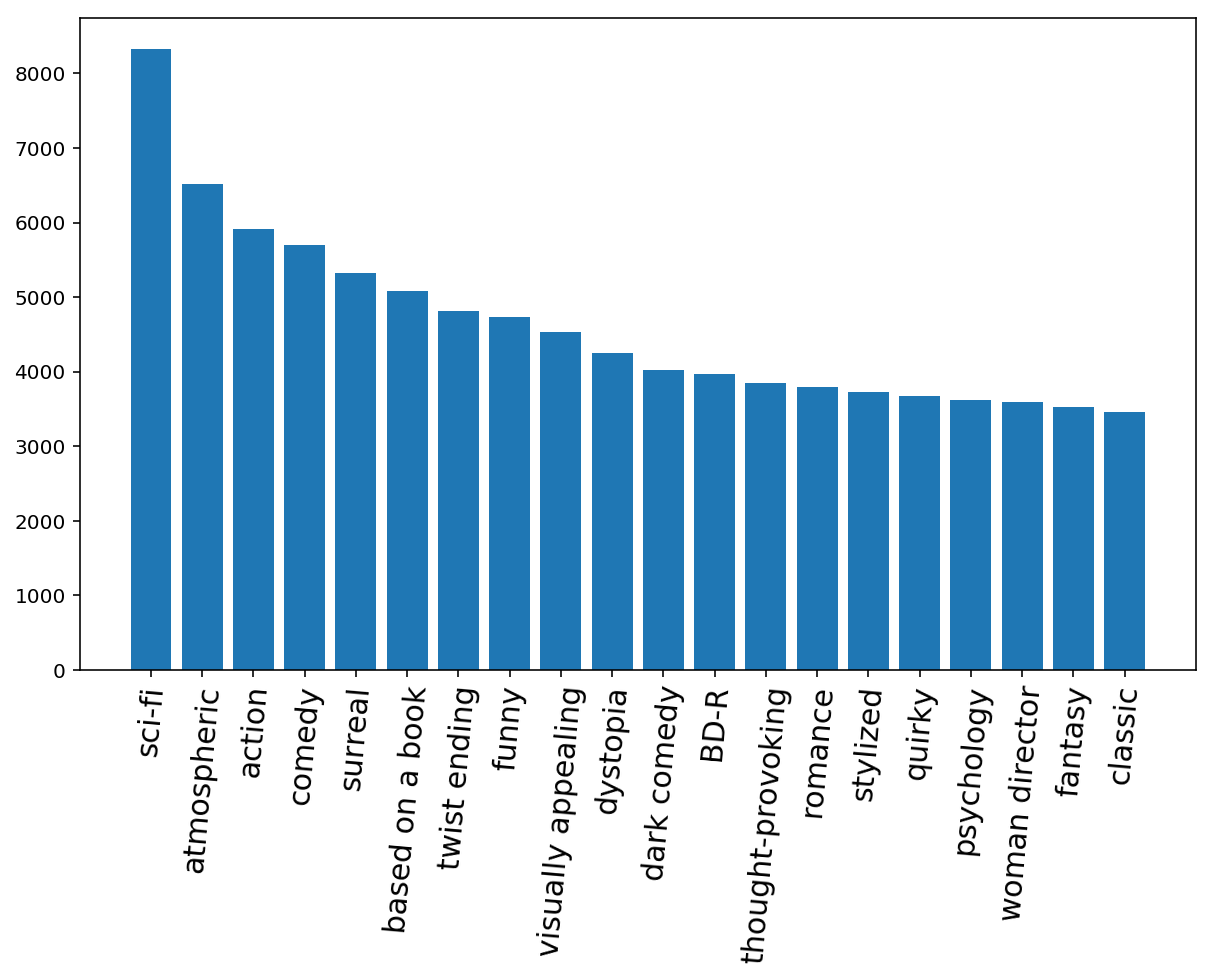

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
%%time
######################################
######### YOUR CODE HERE #############
######################################

num_ratings = ratings \
    .map(lambda row: (row.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .mapValues(lambda row: (row[0], row[1][1])) \
    .sortBy(lambda row: row[1][0], ascending=False)

pd.DataFrame(num_ratings.values().take(10))

CPU times: user 47.2 ms, sys: 5.83 ms, total: 53 ms
Wall time: 29.8 s


,0,1
0,81491,Forrest Gump (1994)
1,81482,"""Shawshank Redemption"
2,79672,Pulp Fiction (1994)
3,74127,"""Silence of the Lambs"
4,72674,"""Matrix"
5,68717,Star Wars: Episode IV - A New Hope (1977)
6,64144,Jurassic Park (1993)
7,60411,Schindler's List (1993)
8,59184,Braveheart (1995)
9,58773,Fight Club (1999)


### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [25]:
%%time
######################################
######### YOUR CODE HERE #############
######################################

ans = ratings \
    .filter(lambda row: row.rating == 5) \
    .map(lambda row: (row.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .join(movies) \
    .mapValues(lambda row: (row[0], row[1][1])) \
    .sortBy(lambda row: row[1][0], ascending=False) \
    .values().take(10)

pd.DataFrame(ans)

CPU times: user 43.2 ms, sys: 11.1 ms, total: 54.3 ms
Wall time: 25.6 s


,0,1
0,39553,"""Shawshank Redemption"
1,32169,Pulp Fiction (1994)
2,25918,Forrest Gump (1994)
3,25804,Star Wars: Episode IV - A New Hope (1977)
4,25482,"""Matrix"
5,24853,Schindler's List (1993)
6,24801,"""Silence of the Lambs"
7,24418,"""Godfather"
8,21585,"""Usual Suspects"
9,21486,Fight Club (1999)


### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

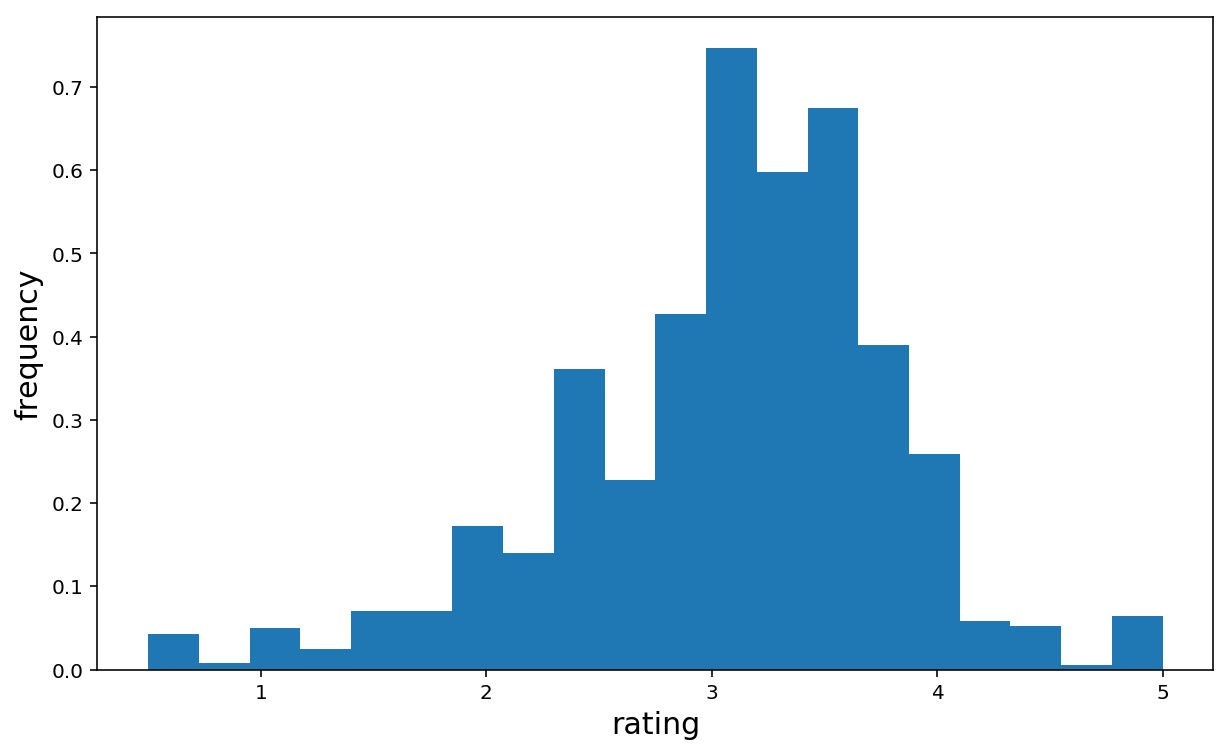

In [26]:
######################################
######### YOUR CODE HERE #############
######################################

temp = movie_avg_rating.values().collect()
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(temp, density=True, bins=20)
plt.xlabel('rating', fontsize=15)
plt.ylabel('frequency', fontsize=15)
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [27]:
%%time

######################################
######### YOUR CODE HERE #############
######################################

temp = num_ratings.values().collect()

print(temp)

# Матплотлиб на таком большом графике у меня локально умер :(
# Ниже код, который должен нарисовать график

# f, ax = plt.subplots(figsize=(10, 6))
# plt.hist(temp, density=True)
# plt.xlabel('number of ratings', fontsize=15)
# plt.ylabel('frequency', fontsize=15)
# plt.show()

[(81491, 'Forrest Gump (1994)'), (81482, '"Shawshank Redemption'), (79672, 'Pulp Fiction (1994)'), (74127, '"Silence of the Lambs'), (72674, '"Matrix'), (68717, 'Star Wars: Episode IV - A New Hope (1977)'), (64144, 'Jurassic Park (1993)'), (60411, "Schindler's List (1993)"), (59184, 'Braveheart (1995)'), (58773, 'Fight Club (1999)'), (57379, 'Terminator 2: Judgment Day (1991)'), (57361, 'Star Wars: Episode V - The Empire Strikes Back (1980)'), (57309, 'Toy Story (1995)'), (55736, '"Lord of the Rings: The Fellowship of the Ring'), (55366, '"Usual Suspects'), (54917, 'Star Wars: Episode VI - Return of the Jedi (1983)'), (54675, 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'), (53689, 'American Beauty (1999)'), (52498, '"Godfather'), (51138, '"Lord of the Rings: The Two Towers'), (50797, '"Lord of the Rings: The Return of the King'), (50596, 'Seven (a.k.a. Se7en) (1995)'), (49638, '"Fugitive'), (49595, 'Back to the Future (1985)'), (48902, 'Independence D

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

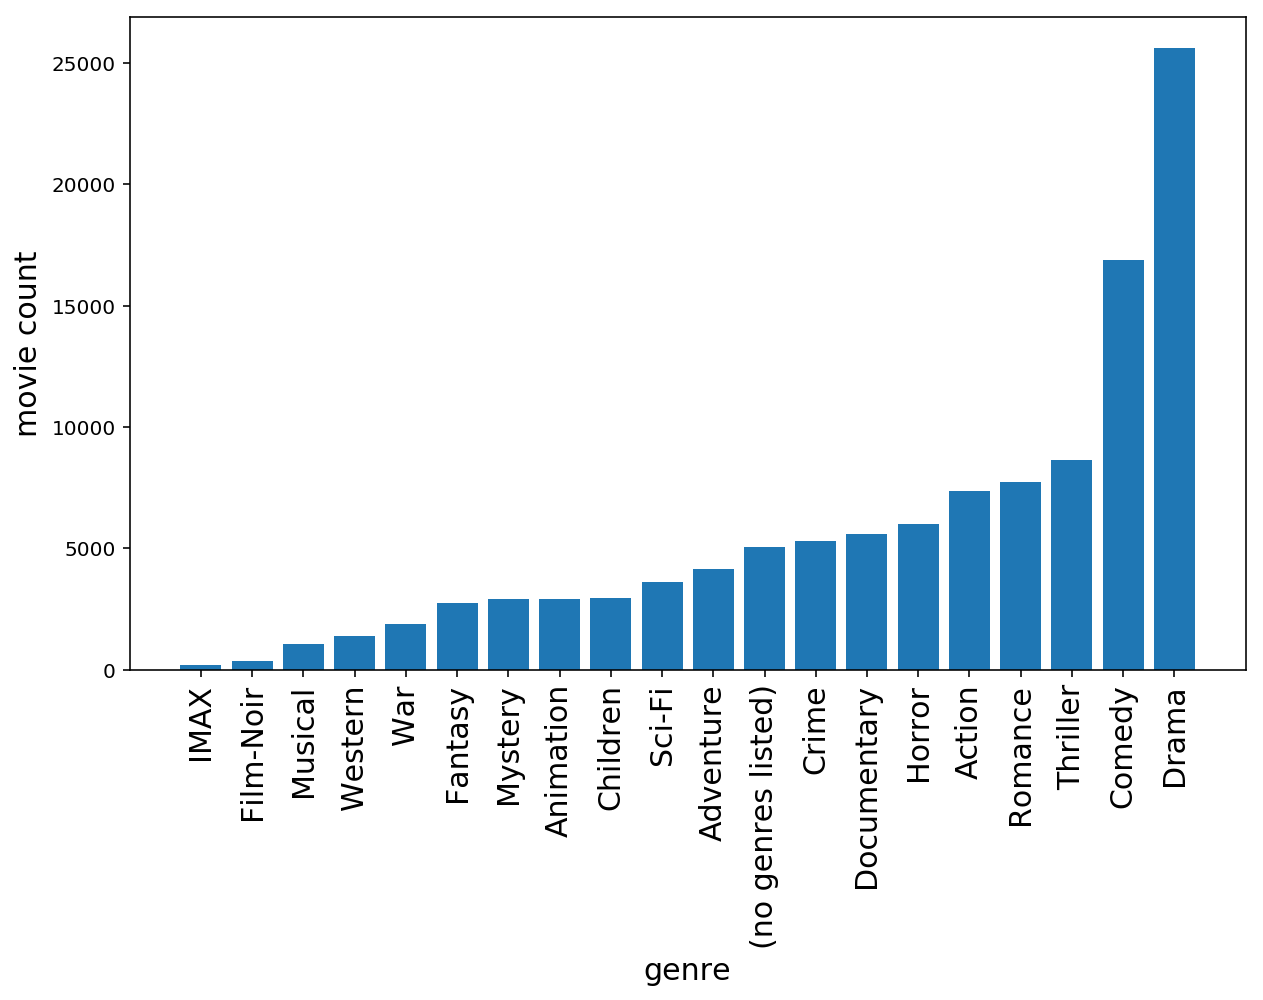

In [29]:
######################################
######### YOUR CODE HERE #############
######################################

movies = sc.textFile(MOVIES_PATH)

r0, r1 = zip(*sorted(movies \
                    .filter(lambda row: row[0].isdigit()) \
                    .flatMap(lambda row: row.split(',')[-1].split('|')) \
                    .countByValue().items(), key=lambda row: row[1]))

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=90, fontsize=15)
plt.bar(r0, r1, align="center")
plt.xlabel('genre', fontsize=15)
plt.ylabel('movie count', fontsize=15)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [30]:
%%time

######################################
######### YOUR CODE HERE #############
######################################

LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

links = sc.textFile(LINKS_PATH)
tmdb = sc.textFile(TMDB_PATH)

id_pairs = links \
    .filter(lambda row: 'tmdbId' not in row and row) \
    .map(lambda row: row.split(',')) \
    .filter(lambda row: all(row)) \
    .keyBy(lambda row: int(row[-1])) \
    .map(lambda row: (row[0], int(row[1][0])))

titles = movies \
    .filter(lambda row: row[0].isdigit()) \
    .map(lambda row: row.split(',')[:2]) \
    .map(lambda row: (int(row[0]), row[1])) \

tom_movies = tmdb.map(lambda row: json.loads(row)) \
    .filter(lambda row: 'id' in row) \
    .flatMap(lambda row: [(row['id'], actor['id']) for actor in row['casts']['cast'] if actor['name'] == "Tom Hanks"])

CPU times: user 3.84 ms, sys: 0 ns, total: 3.84 ms
Wall time: 75 ms


In [31]:
%%time

ans = tom_movies \
    .join(id_pairs) \
    .map(lambda row: (row[1][1], row[0])) \
    .join(titles) \
    .map(lambda row: row[1][1]) \
    .collect()

pd.DataFrame(ans)

CPU times: user 47.2 ms, sys: 0 ns, total: 47.2 ms
Wall time: 7.12 s


,0
0,Sleepless in Seattle (1993)
1,"""Celluloid Closet"
2,Elvis Has Left the Building (2004)
3,"""'burbs"
4,Splash (1984)
5,Every Time We Say Goodbye (1986)
6,"""League of Their Own"
7,Captain Phillips (2013)
8,Toy Story of Terror (2013)
9,Shooting War (2000)


In [32]:
ans = tmdb.map(lambda row: json.loads(row)) \
    .filter(lambda row: 'id' in row) \
    .flatMap(lambda row: [actor['name'] for actor in row['casts']['cast']]) \
    .map(lambda row: (row, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda row: row[1], ascending=False) \
    .take(10)

pd.DataFrame(ans)

,0,1
0,Bess Flowers,380
1,Frank Welker,184
2,Christopher Lee,175
3,Clarence Nash,158
4,Irving Bacon,152
5,John Carradine,146
6,John Wayne,142
7,Mel Blanc,140
8,Samuel L. Jackson,134
9,Eric Roberts,133


### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [33]:
######################################
######### YOUR CODE HERE #############
######################################

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

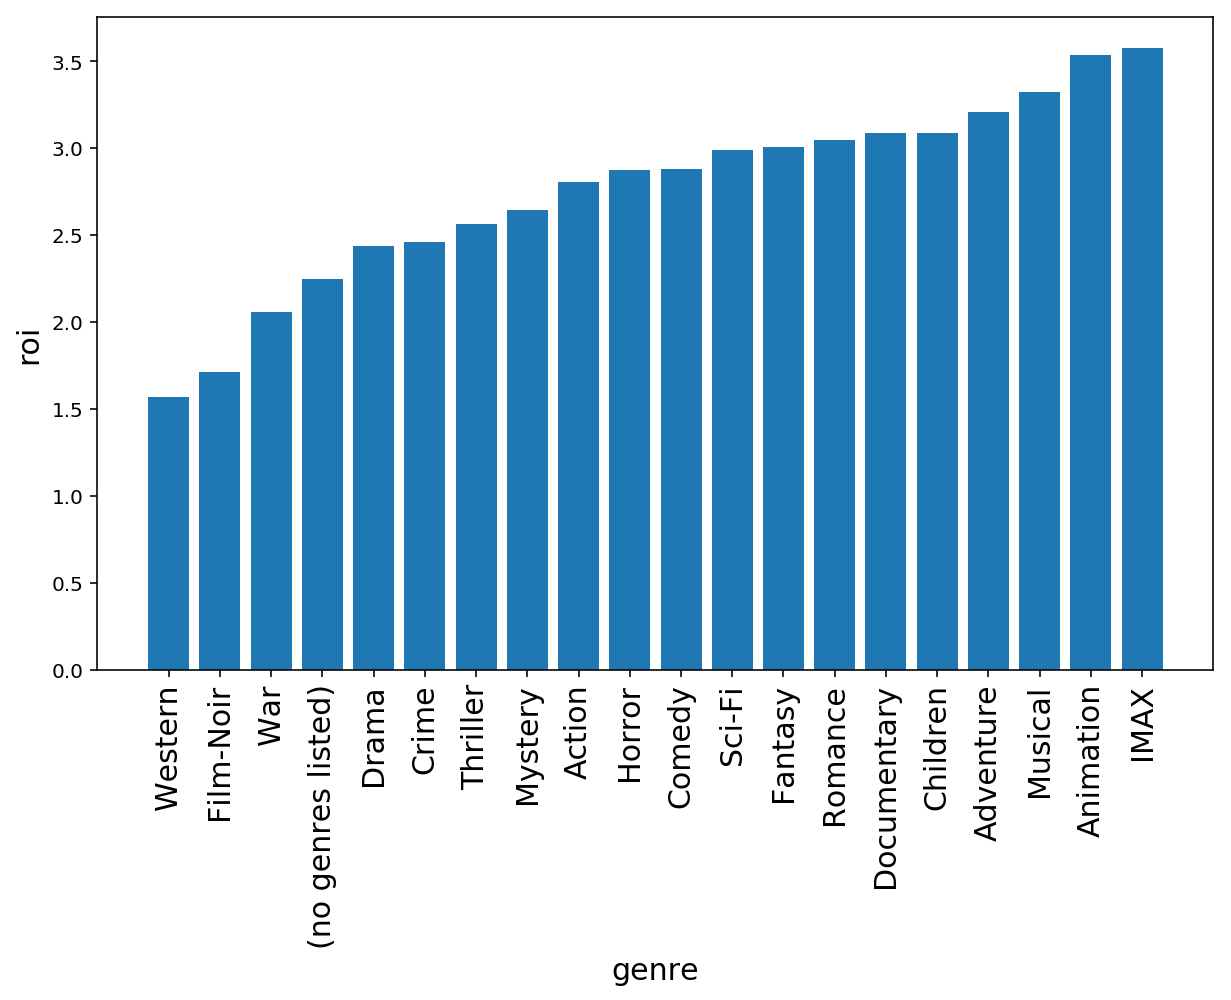

CPU times: user 596 ms, sys: 422 ms, total: 1.02 s
Wall time: 6.71 s


In [34]:
%%time
######################################
######### YOUR CODE HERE #############
######################################

movie_genres = movies \
    .filter(lambda row: row[0].isdigit()) \
    .map(lambda row: (int(row.split(',')[0]),  row.split(',')[-1].split('|'))) \
    .flatMap(lambda row: [(row[0], genre) for genre in row[1]])

roi = tmdb.map(lambda row: json.loads(row)) \
    .filter(lambda row: 'id' in row) \
    .map(lambda row: (row['id'], (row['revenue'], row['budget']))) \
    .join(id_pairs) \
    .map(lambda row: (row[1][1], row[1][0])) \
    .join(movie_genres) \
    .map(lambda row: (row[1][1], row[1][0])) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda row: row[0] / row[1]) \
    .collect()

r0, r1 = zip(*sorted(roi, key=lambda row: row[1]))

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=90, fontsize=15)
plt.bar(r0, r1, align="center")
plt.xlabel('genre', fontsize=15)
plt.ylabel('roi', fontsize=15)
plt.show()